<a href="https://colab.research.google.com/github/maikejulie/DNN4Cli/blob/main/THOR/Step2/Step2_THOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
from sklearn.preprocessing import StandardScaler
from scipy.io import loadmat
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import *

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# THOR Bayesian Neural Network Approach


In Step 2 of THOR, a deterministic neural network is used to predict ocean regimes. Here we instead use a Bayesian Neural Network which allows the uncertainty of the predictions to be quantified. This notebook should therefore be seen as an alternative for Step 2 of the deterministic THOR framework.

The input features are the same as those for the deterministic network and we use the classes obtained from step 1 as labels to train a classifier that takes other types of inputs (justification of the choices are in Sonnewald et al. (2021)). The inputs are:

1.   Wind stress curl
2.   Mean SSH (20 years)
3.   Gradients of mean SSH
4.   Bathymetry
5.   Gradients of bathymetry
6.   Coriolis

In [ ]:
monthlySSH = xr.open_mfdataset('/content/gdrive/MyDrive/SSHdata/SSH.*.nc', combine='by_coords')
monthlySSH

<xarray.Dataset>
Dimensions:  (i1: 240, i2: 360, i3: 720)
Coordinates:
  * i1       (i1) float64 1.0 2.0 3.0 4.0 5.0 ... 236.0 237.0 238.0 239.0 240.0
  * i2       (i2) float64 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0
  * i3       (i3) float64 1.0 2.0 3.0 4.0 5.0 ... 716.0 717.0 718.0 719.0 720.0
    lon      (i2, i3) float64 dask.array<chunksize=(360, 720), meta=np.ndarray>
    lat      (i2, i3) float64 dask.array<chunksize=(360, 720), meta=np.ndarray>
    tim      (i1) datetime64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
Data variables:
    SSH      (i1, i2, i3) float64 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
Attributes: (12/31)
    description:               SSH -- ECCO v4 ocean state estimate, release 3...
    A:                         :Format      = interpolated (half degree grid)
    B:                         :source      = ECCO consortium (http://ecco-gr...
    C:                         :institution = JPL/UT/MIT/AER
    D:                         :history     = files revision history :
    E:                                            04/20/2017: fill in geometr...
    ...                        ...
    Conventions:               CF-1.6
    _FillValue:                nan
    missing_value:             nan
    history:                   Thu Mar  1 15:28:39 2018: ncea -F -d i1,1,12 ....
    nco_openmp_thread_number:  1
    program:                   file created using gcmfaces_IO/write2nctiles.m \n

Calculate 20 years mean of sea surface height

/usr/local/lib/python3.7/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.7/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


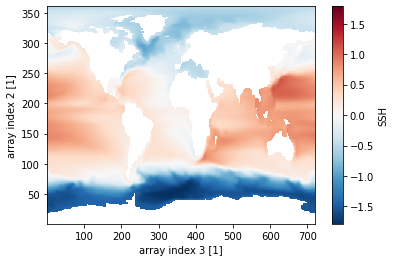

In [ ]:
monthlySSH['SSH'].mean(axis=0).plot()
SSH20mean = monthlySSH['SSH'].mean(axis=0).values

Read Bathymetry file

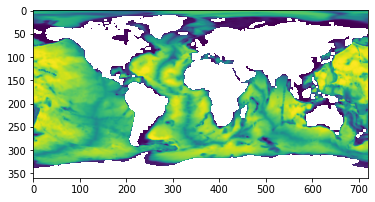

In [ ]:
Bathm = np.transpose(loadmat('/content/gdrive/MyDrive/DNN4Cli/THOR/Step2/Data_Step2/H_wHFacC.mat')['val'])
plt.imshow(np.flipud(Bathm))

Read CurlTau file

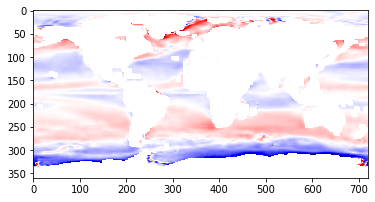

In [ ]:
curlTau = np.transpose(np.load('/content/gdrive/MyDrive/DNN4Cli/THOR/Step2/Data_Step2/curlTau.npy'))
plt.imshow(np.flipud(curlTau), cmap='seismic')
plt.clim(-1e-9,1e-9)

Read the class labels from Sonnewald et al. 2019. Originally there were 50 classes, here we keep the most representative first 5 classes and group the rest in one class. Please refer to the article for more details.


In [ ]:
ecco_label = np.transpose(np.load('/content/gdrive/MyDrive/DNN4Cli/THOR/Step2/Data_Step2/kCluster6.npy'))
ecco_label.shape

(360, 720)

Replace land pixels (label=-1) by NaNs

In [ ]:
ecco_label[ecco_label==-1] = np.nan

## Calculate Features 
### We need [CurlTau, SSH20mean, $\nabla$SSH20mean, Bathm, $\nabla$Bathm, Coriolis]

Calculating the coriolis and the gradients of the SSH20mean and the bathymetry

In [ ]:
lonRoll = np.roll(monthlySSH['lat'].values, axis=0, shift=-1)
Londiff = lonRoll - monthlySSH['lat'].values  # equivalent to doing x_{i} - x_{i-1}

lat = monthlySSH['lat'].values
latDiff=1.111774765625000e+05
latY=np.gradient(lat, axis=0)*latDiff
lonX=np.abs(np.cos(lat*np.pi/180))*latDiff*Londiff

##coriolis 
Omega=7.2921e-5 # coriolis parameter
f = (2*Omega*np.sin(lat*np.pi/180))

def grad(d,y,x):
    grady=np.gradient(d, axis=0)/y
    gradx=np.gradient(d, axis=1)/x
    return grady, gradx

gradSSH_y, gradSSH_x = grad(SSH20mean,latY,lonX)
gradBathm_y, gradBathm_x = grad(Bathm,latY,lonX)

Text(0.5, 1.0, 'gradBathm_y')

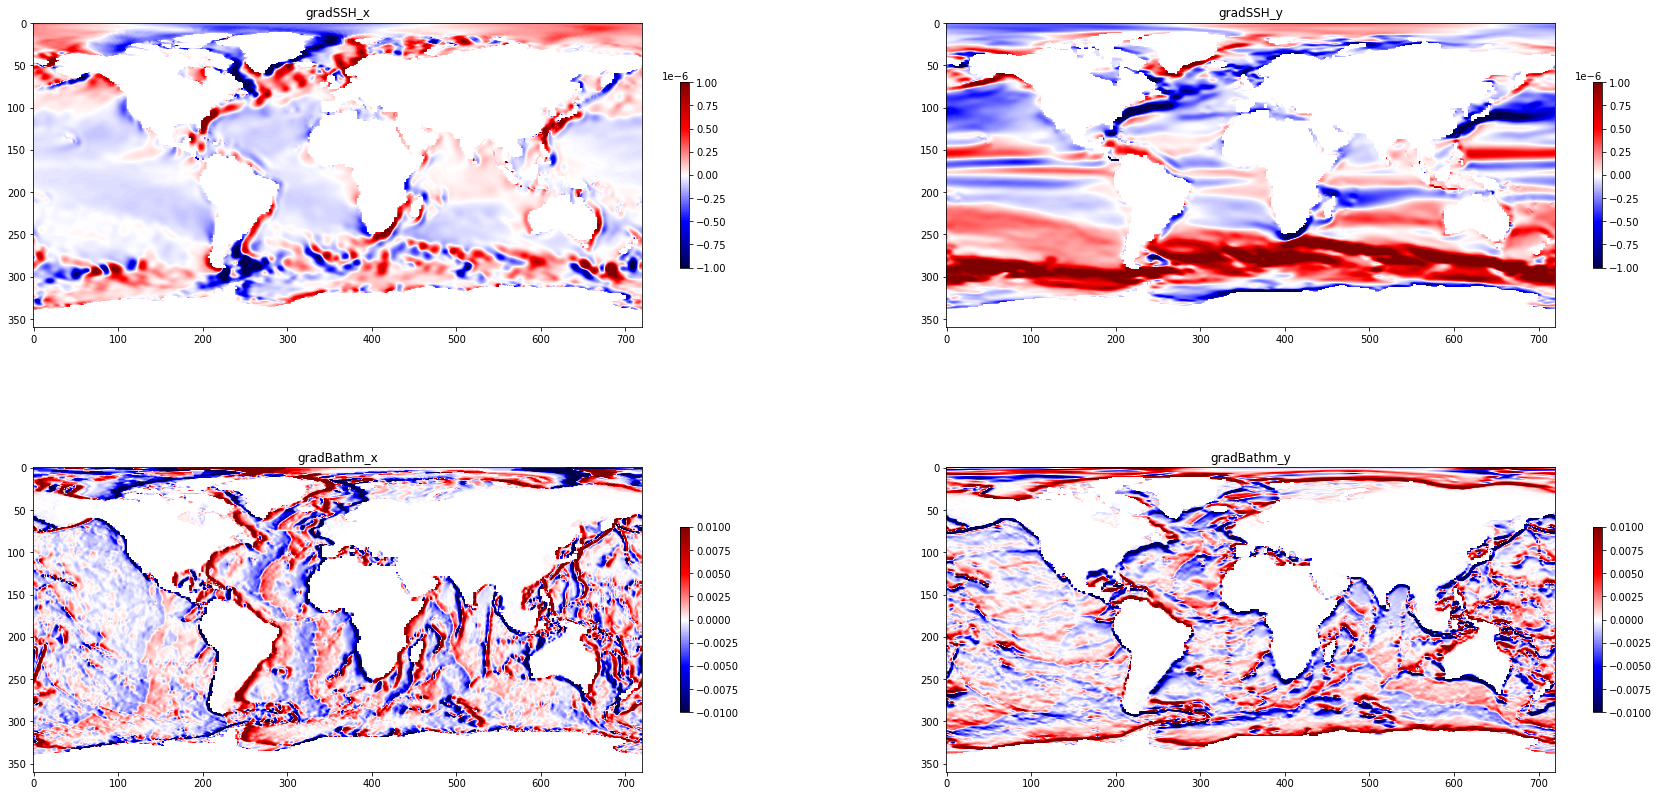

In [ ]:
plt.figure(figsize=(30,15))

plt.subplot(2,2,1)
plt.imshow(np.flipud(gradSSH_x), cmap='seismic')
plt.colorbar(shrink=0.5)
plt.clim(-1e-6,1e-6)
plt.title('gradSSH_x')

plt.subplot(2,2,2)
plt.imshow(np.flipud(gradSSH_y), cmap='seismic')
plt.colorbar(shrink=0.5)
plt.clim(-1e-6,1e-6)
plt.title('gradSSH_y')

plt.subplot(2,2,3)
plt.imshow(np.flipud(gradBathm_x), cmap='seismic')
plt.colorbar(shrink=0.5)
plt.clim(-1e-2,1e-2)
plt.title('gradBathm_x')

plt.subplot(2,2,4)
plt.imshow(np.flipud(gradBathm_y), cmap='seismic')
plt.colorbar(shrink=0.5)
plt.clim(-1e-2,1e-2)
plt.title('gradBathm_y')

Mask land pixels and other noisy locations

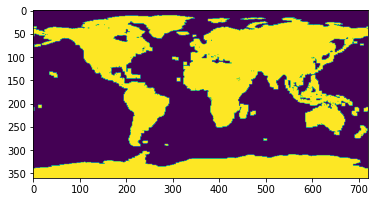

In [ ]:
missingdataindex = np.isnan(curlTau*SSH20mean*gradSSH_x*gradSSH_y*Bathm*gradBathm_x*gradBathm_y)
plt.imshow(np.flipud(missingdataindex))

Mask for training data = previous mask + masking the Atlantic Ocean

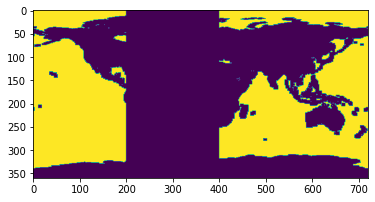

In [ ]:
maskTraining = (~missingdataindex).copy()
maskTraining[:,200:400]=False
plt.imshow(np.flipud(maskTraining))

Land mask for Atlantic Ocean

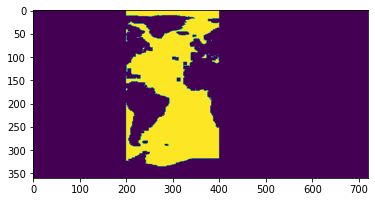

In [ ]:
maskVal = (~missingdataindex).copy()
maskVal[:,list(range(200))+list(range(400,720))]=False
plt.imshow(np.flipud(maskVal))

In [ ]:
TotalDataset = np.stack((curlTau[~missingdataindex],
                         SSH20mean[~missingdataindex],
                         gradSSH_x[~missingdataindex],
                         gradSSH_y[~missingdataindex],
                         Bathm[~missingdataindex],
                         gradBathm_x[~missingdataindex],
                         gradBathm_y[~missingdataindex],
                         f[~missingdataindex]),1)

TrainDataset = np.stack((curlTau[maskTraining],
                         SSH20mean[maskTraining],
                         gradSSH_x[maskTraining],
                         gradSSH_y[maskTraining],
                         Bathm[maskTraining],
                         gradBathm_x[maskTraining],
                         gradBathm_y[maskTraining],
                         f[maskTraining]),1)

ValDataset = np.stack((curlTau[maskVal],
                         SSH20mean[maskVal],
                         gradSSH_x[maskVal],
                         gradSSH_y[maskVal],
                         Bathm[maskVal],
                         gradBathm_x[maskVal],
                         gradBathm_y[maskVal],
                       f[maskVal]),1)

TotalDataset.shape, TrainDataset.shape, ValDataset.shape

((149587, 8), (109259, 8), (40328, 8))

In [ ]:
train_label = ecco_label[maskTraining]
val_label = ecco_label[maskVal]
train_label.shape, val_label.shape

((109259,), (40328,))

# Training the Bayesian Neural Network (BNN)

Scale the data

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(TrainDataset)
scaler.mean_,scaler.scale_

(array([-2.20681035e-11,  7.85894841e-03,  1.92149912e-08,  1.38805767e-07,
         3.96657293e+03, -1.45941754e-04,  5.42086609e-04, -1.21754470e-05]),
 array([1.46399667e-10, 7.07289355e-01, 1.89893314e-07, 4.55081599e-07,
        1.44475515e+03, 4.87804804e-03, 4.64697134e-03, 9.54868121e-05]))

In [ ]:
X_train_scaled = scaler.transform(TrainDataset)
X_val_scaled = scaler.transform(ValDataset)

To use a BNN we must import both `tensorflow` and `tensorflow_probability`

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop

Y_train = tf.keras.utils.to_categorical(train_label)
Y_val = tf.keras.utils.to_categorical(val_label)

In BNNs, the weights are distributions rather than deterministic. Therefore we must define a fixed prior for each of the weights and the general shape for the posterior

In [ ]:
# Define the prior weight distribution -- all N(0, 1) -- and not trainable

def prior(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size
    prior_model = Sequential([
                            tfpl.DistributionLambda(
                                lambda t: tfd.MultivariateNormalDiag(loc = tf.zeros(n), scale_diag = tf.ones(n))
                            )
    ]) # normal distribution for each weight in the layer
    return prior_model

# Define variational posterior weight distribution -- multivariate Gaussian

def posterior(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size
    posterior_model = Sequential([
                tfpl.VariableLayer(2*n, dtype=dtype),
                tfpl.DistributionLambda (
        lambda t: tfd.MultivariateNormalDiag(loc = t[..., :n], scale_diag = tf.math.exp(t[..., n:])))
    ]) # define posterior for each weight in the layer
    return posterior_model


#### Define the network. 

Dense layers in a deterministic network are replaced with DenseVariational layers in a BNN.
Using a OneHotCategorical layer as the output layer means that the output of the network is also a distribution.

In [ ]:
model = Sequential([
    tfpl.DenseVariational(input_shape = (8,), units =24,
                          activation = tf.keras.activations.tanh,
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight = 1/X_train_scaled.shape[0], # have to rescale the kl_error
                          kl_use_exact=True # use if have analytic form of prior and posterior - may error in which case change to False
                          ),
    tfpl.DenseVariational(units =24,
                          activation = tf.keras.activations.tanh,
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight = 1/X_train_scaled.shape[0], # have to rescale the kl_error
                          kl_use_exact=True # use if have analytic form of prior and posterior - may error in which case change to False
                          ),
    tfpl.DenseVariational(units =16,
                          activation = tf.keras.activations.tanh,
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight = 1/X_train_scaled.shape[0], # have to rescale the kl_error
                          kl_use_exact=True # use if have analytic form of prior and posterior - may error in which case change to False
                          ),
    tfpl.DenseVariational(units =16,
                          activation = tf.keras.activations.tanh,
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight = 1/X_train_scaled.shape[0], # have to rescale the kl_error
                          kl_use_exact=True # use if have analytic form of prior and posterior - may error in which case change to False
                          ),                    
    tfpl.DenseVariational(units =6,
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight = 1/X_train_scaled.shape[0], # have to rescale the kl_error
                          kl_use_exact=True # use if have analytic form of prior and posterior - may error in which case change to False
                          ),
   tfpl.OneHotCategorical(6)])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational (DenseVar  (None, 24)               432       
 iational)                                                       
                                                                 
 dense_variational_1 (DenseV  (None, 24)               1200      
 ariational)                                                     
                                                                 
 dense_variational_2 (DenseV  (None, 16)               800       
 ariational)                                                     
                                                                 
 dense_variational_3 (DenseV  (None, 16)               544       
 ariational)                                                     
                                                                 
 dense_variational_4 (DenseV  (None, 6)                2

Define the loss function as the negative log-likelihood

In [ ]:
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])

Train the model using a callback which reduces the learning rate if the validation loss does not decrease after 15 epochs.

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    '/content/gdrive/MyDrive/DNN4Cli/THOR/model_best_bayesian_weights_tanh_dv.h5', monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch')

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
            monitor = 'val_loss',
            patience=15,
            factor=0.25,
            verbose=1)

history = model.fit(X_train_scaled, Y_train,
                    batch_size=32,
                    epochs=100,
                    verbose=1,
                    validation_split = 0.2, shuffle = True,
                    callbacks = [checkpoint_callback, reduce_lr_callback])

Epoch 1/100
2732/2732 [==============================] - 25s 7ms/step - loss: 2.0745 - accuracy: 0.2107 - val_loss: 1.6579 - val_accuracy: 0.2219 - lr: 0.0100
Epoch 2/100
2732/2732 [==============================] - 10s 4ms/step - loss: 1.6896 - accuracy: 0.2117 - val_loss: 1.6327 - val_accuracy: 0.2262 - lr: 0.0100
Epoch 3/100
2732/2732 [==============================] - 9s 3ms/step - loss: 1.3188 - accuracy: 0.3300 - val_loss: 1.4270 - val_accuracy: 0.3731 - lr: 0.0100
Epoch 4/100
2732/2732 [==============================] - 8s 3ms/step - loss: 0.8138 - accuracy: 0.5723 - val_loss: 1.1663 - val_accuracy: 0.5151 - lr: 0.0100
Epoch 5/100
2732/2732 [==============================] - 8s 3ms/step - loss: 0.6884 - accuracy: 0.6348 - val_loss: 0.8517 - val_accuracy: 0.6013 - lr: 0.0100
Epoch 6/100
2732/2732 [==============================] - 9s 3ms/step - loss: 0.6225 - accuracy: 0.6803 - val_loss: 0.9267 - val_accuracy: 0.5993 - lr: 0.0100
Epoch 7/100
2732/2732 [===========================

In [ ]:
print(model.evaluate(X_train_scaled, Y_train))
print(model.evaluate(X_val_scaled, Y_val))

3415/3415 [==============================] - 7s 2ms/step - loss: 0.3836 - accuracy: 0.8440
[0.3836072087287903, 0.8440311551094055]
1261/1261 [==============================] - 3s 2ms/step - loss: 0.5839 - accuracy: 0.7661
[0.5839307308197021, 0.7660682201385498]


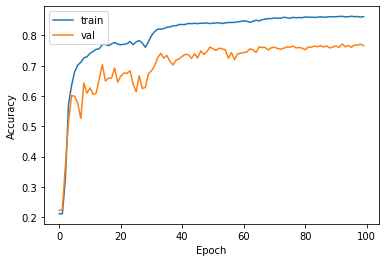

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

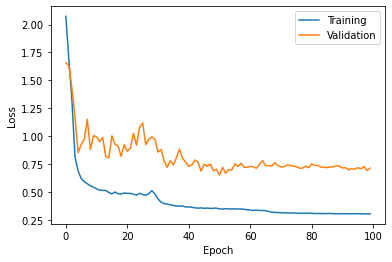

In [ ]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

BNNs allow us to easily generate an ensemble of deterministic neural networks simply by sampling from the distribution

In [ ]:
from keras.layers import Dense, Input

for j in range(1000):
    # build framework for deterministic network
    det_model = Sequential([
    Input(shape = (8,)),
    Dense(units = 24, activation = tf.keras.activations.tanh),
    Dense(units = 24, activation = tf.keras.activations.tanh),
    Dense(units = 16, activation = tf.keras.activations.tanh),
    Dense(units = 16, activation = tf.keras.activations.tanh),
    Dense(units =6),
    tfpl.OneHotCategorical(6)])

    det_model.compile(loss=nll,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

    dummy_input = np.array([[1]])

    for i in range(len(det_model.layers)-1):
        # sample the weights from the BNN
        model_posterior = model.layers[i]._posterior(dummy_input)
        posterior_weights = model_posterior.sample()
        x, y = det_model.layers[i].weights[0].shape
        # assign the sampled weights to the deterministic network
        det_model.layers[i].set_weights([posterior_weights.numpy()[:(x*y)].reshape(det_model.layers[i].weights[0].shape), posterior_weights.numpy()[(x*y):]])
        det_model.save_weights('/content/gdrive/MyDrive/DNN4Cli/THOR/bayesian_ensemble/model_' + str(j) + '.h5')


## Assessing the performance of the BNN

Define functions to analyse model predictions versus true labels

In [ ]:
def boxplot_model_predictions(prob_predictions, point_num, labels, run_ensemble = True):
    # Print the true activity
    print('------------------------------')
    print('True cluster:', labels[point_num])
    print('')

    # Print the probabilities the model assigns
    print('------------------------------')
    print('Model estimated probabilities:')
    # Create ensemble of predicted probabilities

    predicted_probabilities = prob_predictions[:, point_num, :]
    box = plt.boxplot(predicted_probabilities, positions = [0, 1, 2, 3, 4, 5])
    for i in range(6):
        if i == int(labels[point_num]):
            plt.setp(box['boxes'][i], color='green')
            plt.setp(box['medians'][i], color='green')
        else:
            plt.setp(box['boxes'][i], color='purple')
            plt.setp(box['medians'][i], color='purple')
    plt.ylim([0, 1])
    plt.ylabel('Probability')
    plt.xticks([0, 1, 2, 3, 4, 5], ["F", "E", "D", "C", "B", "A"])
    plt.xlim([5.5, -0.5])
    plt.show()        
    return predicted_probabilities

def ci_model_predictions(prob_mean, conf_low, conf_high, point_num, labels, run_ensemble = True):
    # Print the true activity
    print('------------------------------')
    print('True cluster:', labels[point_num])
    print('')

    # Print the probabilities the model assigns
    print('------------------------------')
    print('Model estimated probabilities:')
    # Create ensemble of predicted probabilities

    fig, ax = plt.subplots(figsize = (3, 4))
    predicted_probabilities = prob_mean[point_num, :]
    ci = conf_high[point_num, :] - prob_mean[point_num, :]
    for i in range(6):
        if i == int(labels[point_num]):
            ax.errorbar(x = [i], y = predicted_probabilities[i], yerr = ci[i], fmt = 'o', 
             color = 'green', markersize = 3, capsize = 10)
        else:
            ax.errorbar(x = [i], y = predicted_probabilities[i], yerr = ci[i], fmt = 'o', 
             color = 'purple', markersize = 3, capsize = 10)        
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    ax.set_xticks([0, 1, 2, 3, 4, 5])
    ax.set_xlim([5.5, -0.5])
    ax.set_xticklabels(["F", "E", "D", "C", "B", "A"])
    plt.show()        

    
def get_correct_indices(prob_mean, labels):
    correct = np.argmax(prob_mean, axis=1) == np.argmax(labels, axis = 1)
    correct_indices = [i for i in range(prob_mean.shape[0]) if correct[i]]
    incorrect_indices = [i for i in range(prob_mean.shape[0]) if not correct[i]]
    return correct_indices, incorrect_indices

def get_correct_indices_total(model, x, labels):
    y_model = model(x)
    correct = np.argmax(y_model.mean(), axis = 1) == labels
    correct_indices = [i for i in range(x.shape[0]) if correct[i]]
    incorrect_indices = [i for i in range(x.shape[0]) if not correct[i]]
    return correct_indices, incorrect_indices

def plot_entropy_distribution(prob_mean, labels):
    entropy = -np.sum(prob_mean * np.log2(prob_mean), axis=1)
    corr_indices, incorr_indices = get_correct_indices(prob_mean, labels)
    indices = [corr_indices, incorr_indices]
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for i, category in zip(range(2), ['Correct', 'Incorrect']):
        entropy_category = np.array([entropy[j] for j in indices[i]])
        mean_entropy = np.mean(entropy_category[~np.isnan(entropy_category)])
        num_samples = entropy_category.shape[0]
        #title = category + 'ly labelled ({:.2f}% of total)'.format(num_samples / x.shape[0] * 100)
        title = category + 'ly labelled'.format(num_samples / x.shape[0] * 100)
        axes[i].hist(entropy_category, weights=(1/num_samples)*np.ones(num_samples))
        axes[i].annotate('Mean: {:.3f}'.format(mean_entropy), (0.4, 0.9), ha='center')
        axes[i].set_xlabel('Entropy')
        axes[i].set_ylim([0, 1])
        #axes[i].set_ylabel('Probability')
        axes[i].set_title(title)
        print(num_samples)
    plt.show()

Generate ensemble of predictions from the BNN

In [ ]:
ensemble_size = 200
x = X_val_scaled

prob_predictions = np.empty(shape=(ensemble_size, 40328, 6))
for i in range(ensemble_size):
    prob_predictions[i] = model(x).mean().numpy()

prob_mean = prob_predictions.mean(axis = 0)

Calculate confidence intervals of the distributions of the probabilities of each regime (assuming normal)

In [ ]:
import numpy as np, scipy.stats as st
a = prob_predictions[:, :, :]
conf_low, conf_high = st.t.interval(0.95, len(a)-1, loc=np.mean(a, axis = 0), scale=st.sem(a, axis = 0))

Plot accuracy of predictions

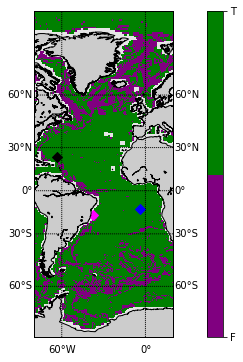

In [ ]:
lat = monthlySSH['lat']
lon = monthlySSH['lon']

c_in, inc_in = get_correct_indices(prob_mean, Y_val)
missing_results = np.nan * np.zeros((360*720))
extra_results = missing_results[maskVal.flatten()]
extra_results[c_in] = 1
extra_results[inc_in] = 0
missing_results[maskVal.flatten()] = extra_results
missing_results = np.flipud(np.reshape(missing_results,(360,720)))
cmap = matplotlib.colors.ListedColormap(['purple', 'green'])

lons = lon[1,:].values
lats = lat[:,1].values
llons, llats = np.meshgrid(lons,lats)
fig, ax = plt.subplots(figsize = (12,6))
m = Basemap(llcrnrlon=-80, urcrnrlon=20, llcrnrlat=-80, urcrnrlat=89, projection='mill', resolution='l')
m.drawmapboundary(fill_color='0.9')
m.drawparallels(np.arange(-90.,99.,30.),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,0,1])
m.drawcoastlines()
m.fillcontinents()
im1 = m.pcolor(llons, llats, missing_results[::-1,:], cmap=cmap, latlon=True)
cbar = plt.colorbar(pad=0.05)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['F', 'T'])
im2 = m.scatter([-63.25], [23.75], marker = 'D', c = 'black',  s = 50, latlon = True)
im3 = m.scatter([-4.25], [-12.75], marker = 'D', c = 'blue',  s = 50, latlon = True)
im4 = m.scatter([-37.25], [-17.25], marker = 'D', c = 'magenta', s = 50, latlon = True)
plt.show()

Save BNN regime predictions

In [ ]:
pred = np.nan * np.zeros((360*720))
pred[maskVal.flatten()] = prob_mean.argmax(axis = 1)
np.save('/content/gdrive/MyDrive/DNN4Cli/THOR/bnn_pred.npy', np.flipud(np.reshape(pred,(360,720)))[::-1,:])

#### Uncertainty quantification using entropy

Model uncertainty can be quantified by calculating the [entropy](https://en.wikipedia.org/wiki/Entropy_%28information_theory%29) of the distribution. The higher the value, the more unsure the model is

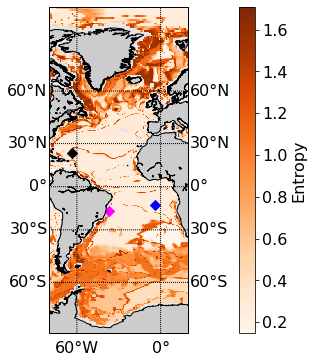

In [ ]:
plt.rcParams.update({'font.size': 16})

entropy = -np.sum(prob_mean* np.log2(prob_mean), axis=1)
all_results = np.nan * np.zeros((360*720))
all_results[maskVal.flatten()] = entropy
lat = monthlySSH['lat']
lon = monthlySSH['lon']
lons = lon[1,:].values
lats = lat[:,1].values
llons, llats = np.meshgrid(lons,lats)
fig, ax = plt.subplots(figsize = (12, 6))
m = Basemap(llcrnrlon=-80, urcrnrlon=20, llcrnrlat=-80, urcrnrlat=89, projection='mill', resolution='l')
m.drawmapboundary(fill_color='0.9')
m.drawparallels(np.arange(-90.,99.,30.),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,0,1])
m.drawcoastlines()
m.fillcontinents()
im1 = m.pcolor(llons, llats, np.flipud(np.reshape(all_results,(360,720)))[::-1,:], latlon=True, cmap = plt.cm.Oranges)
cbar = plt.colorbar(pad=0.075)
cbar.set_label('Entropy')
im2 = m.scatter([-63.25], [23.75], marker = 'D', c = 'black',  s = 50, latlon = True)
im3 = m.scatter([-4.25], [-12.75], marker = 'D', c = 'blue',  s = 50, latlon = True)
im4 = m.scatter([-37.25], [-17.25], marker = 'D', c = 'magenta', s = 50, latlon = True)
plt.show()



32165
8163


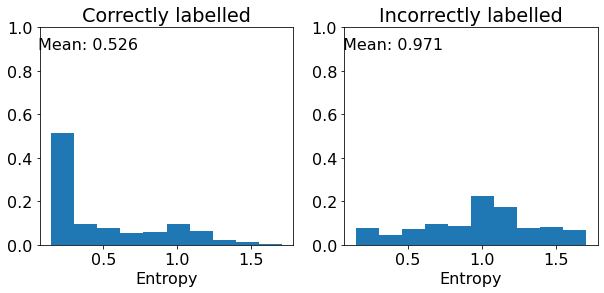

In [ ]:
plot_entropy_distribution(prob_mean, Y_val)

Examples of two output distributions predicted by BNN

23.75
-63.25
------------------------------
True cluster: 2.0

------------------------------
Model estimated probabilities:


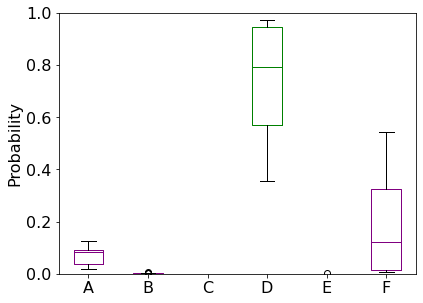

-12.75
-4.25
------------------------------
True cluster: 0.0

------------------------------
Model estimated probabilities:


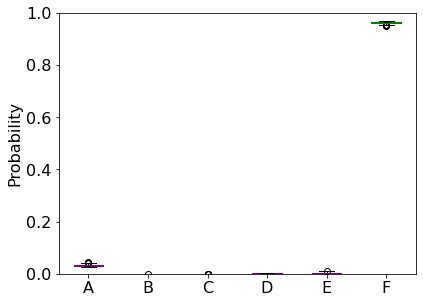

In [ ]:
lat = monthlySSH['lat']
lon = monthlySSH['lon']
lons = lon[1,:].values
lats = lat[:,1].values
llons, llats = np.meshgrid(lons,lats)
plt.rcParams["figure.figsize"] = (6.4, 4.8)

print(llats[maskVal][c_in[107*200]])
print(llons[maskVal][c_in[107*200]])
predicted_prob_0 = boxplot_model_predictions(prob_predictions, c_in[107*200], val_label, run_ensemble = True)

print(llats[maskVal][c_in[75*200]])
print(llons[maskVal][c_in[75*200]])
predicted_prob_0 = boxplot_model_predictions(prob_predictions, c_in[75*200], val_label, run_ensemble = True)

Plot difference between the probability of the predicted regime and the probability of the correct regime

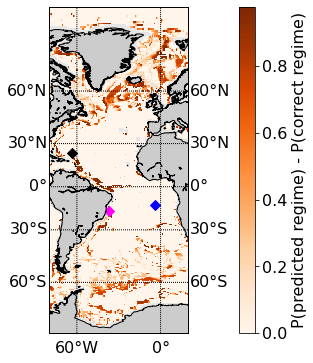

In [ ]:
diff_prob_missing = np.nan * np.zeros((360*720))
j = 0
diff_prob = np.empty(shape = (Y_val.shape[0]))
for i in Y_val.argmax(axis = 1):
    diff_prob[j] = prob_mean[j].max() - prob_mean[j,i]
    j += 1
diff_prob_missing[maskVal.flatten()] = diff_prob

lons = lon[1,:].values
lats = lat[:,1].values
llons, llats = np.meshgrid(lons,lats)
fig, ax = plt.subplots(figsize = (12, 6))
m = Basemap(llcrnrlon=-80, urcrnrlon=20, llcrnrlat=-80, urcrnrlat=89, projection='mill', resolution='l')
m.drawmapboundary(fill_color='0.9')
m.drawparallels(np.arange(-90.,99.,30.),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,0,1])
m.drawcoastlines()
m.fillcontinents()
im1 = m.pcolor(llons, llats, np.flipud(np.reshape(diff_prob_missing,(360,720)))[::-1,:], latlon=True, cmap = plt.cm.Oranges)
cbar = plt.colorbar(pad=0.075)
cbar.set_label(r'P(predicted regime) - P(correct regime)')
im2 = m.scatter([-63.25], [23.75], marker = 'D', c = 'black',  s = 50, latlon = True)
im3 = m.scatter([-4.25], [-12.75], marker = 'D', c = 'blue',  s = 50, latlon = True)
im4 = m.scatter([-37.25], [-17.25], marker = 'D', c = 'magenta', s = 50, latlon = True)
plt.show()

Plot the spatial distribution of the confidence interval value

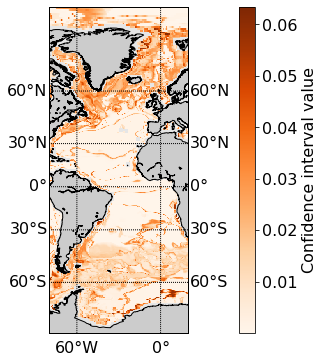

In [ ]:
conf_missing = np.nan * np.zeros((360*720))
conf_int = np.empty(shape = (Y_val.shape[0]))
j = 0
for i in Y_val.argmax(axis = 1):
    conf_int[j] = conf_high[j, i] - prob_mean[j, i]
    j += 1
conf_missing[maskVal.flatten()] = conf_int

lons = lon[1,:].values
lats = lat[:,1].values
llons, llats = np.meshgrid(lons,lats)
fig, ax = plt.subplots(figsize = (12, 6))
m = Basemap(llcrnrlon=-80, urcrnrlon=20, llcrnrlat=-80, urcrnrlat=89, projection='mill', resolution='l')
m.drawmapboundary(fill_color='0.9')
m.drawparallels(np.arange(-90.,99.,30.),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,0,1])
m.drawcoastlines()
m.fillcontinents()
im1 = m.pcolor(llons, llats, np.flipud(np.reshape(conf_missing,(360,720)))[::-1,:], latlon=True, cmap = plt.cm.Oranges)
cbar = plt.colorbar(pad=0.075)
cbar.set_label('Confidence interval value')
plt.show()

Find the locations for which the difference between the probability of the regimes is not statistically significant

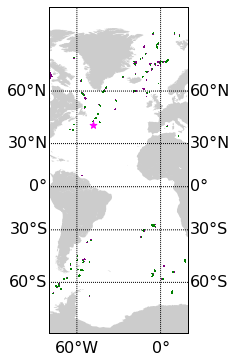

In [ ]:
lons = lon[1,:].values
lats = lat[:,1].values
llons, llats = np.meshgrid(lons,lats)
fig, ax = plt.subplots(figsize = (12,6))

stat_diff_flag = np.empty(shape = (conf_low.shape[0]))
for i in range(conf_low.shape[0]):
    if conf_high[i][np.arange(len(conf_high[i]))!=conf_low[i].argmax()].max() >= conf_low[i].max():
        if extra_results[i] == 1:
            stat_diff_flag[i] = 1
        elif extra_results[i] == 0:
            stat_diff_flag[i] = 0
    else:
        stat_diff_flag[i] = np.nan

stat_diff_missing = np.nan * np.zeros((360*720))
stat_diff_missing[maskVal.flatten()] = stat_diff_flag

m = Basemap(llcrnrlon=-80, urcrnrlon=20, llcrnrlat=-80, urcrnrlat=89, projection='mill', resolution='l')
m.drawmapboundary(fill_color='1')
m.drawparallels(np.arange(-90.,99.,30.),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,0,1])
m.fillcontinents()
cmap = matplotlib.colors.ListedColormap(['purple', 'green'])
im1 = m.contourf(llons, llats, np.flipud(np.reshape(stat_diff_missing,(360,720)))[::-1,:], latlon=True,  cmap = cmap)
im2 = m.scatter([llons[maskVal][30184]], [llats[maskVal][30184]], marker = '*', c = 'magenta',  s = 50, latlon = True)
plt.show()

Example where the difference between the regime probabilities is not statistically significant

Note this is dependent on how the network trains so it may be for your network the difference between the regime probabilities is statistically significant

------------------------------
True cluster: 1.0

------------------------------
Model estimated probabilities:


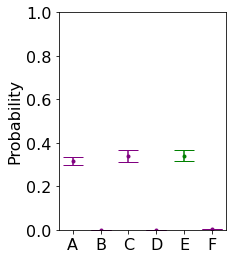

In [ ]:
ci_model_predictions(prob_mean, conf_low, conf_high, 30184, val_label)